In [1]:
"""
BESS Daily Profits Plotter - Profit per MW Analysis with CPLEX Optimization
Uses same CPLEX optimization as profit exporters for accurate arbitrage calculation
Shows profit per MW for fair comparison across configurations
"""

import sys
import os

# Add CPLEX to path if needed (common CPLEX installation paths)
cplex_paths = [
    '/Applications/CPLEX_Studio2211/cplex/python/3.9/x86-64_osx',
    '/Applications/CPLEX_Studio221/cplex/python/3.9/x86-64_osx', 
    '/Applications/CPLEX_Studio_Community221/cplex/python/3.9/x86-64_osx',
    '/opt/ibm/ILOG/CPLEX_Studio221/cplex/python/3.9/x86-64_osx',
    '/usr/local/lib/python3.9/site-packages'
]

# Try to add CPLEX path
for path in cplex_paths:
    if os.path.exists(path) and path not in sys.path:
        sys.path.insert(0, path)
        print(f"Added CPLEX path: {path}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Try importing CPLEX with error handling
try:
    import cplex
    print("✅ CPLEX imported successfully")
    CPLEX_AVAILABLE = True
except ImportError as e:
    print(f"❌ CPLEX import failed: {e}")
    print("Current Python path:")
    for p in sys.path[:5]:  # Show first 5 paths
        print(f"  {p}")
    CPLEX_AVAILABLE = False

# BESS Configuration Parameters
BESS_CONFIGS = [
    {"config_id": 1, "power_mw": 10, "energy_mwh": 10},
    {"config_id": 2, "power_mw": 30, "energy_mwh": 30},
    {"config_id": 3, "power_mw": 50, "energy_mwh": 50},
    {"config_id": 4, "power_mw": 100, "energy_mwh": 100},
    {"config_id": 5, "power_mw": 10, "energy_mwh": 15},
    {"config_id": 6, "power_mw": 50, "energy_mwh": 75},
    {"config_id": 7, "power_mw": 100, "energy_mwh": 150},
    {"config_id": 8, "power_mw": 10, "energy_mwh": 20},
    {"config_id": 9, "power_mw": 30, "energy_mwh": 60},
    {"config_id": 10, "power_mw": 50, "energy_mwh": 100},
    {"config_id": 11, "power_mw": 100, "energy_mwh": 200},
    {"config_id": 12, "power_mw": 200, "energy_mwh": 400},
    {"config_id": 13, "power_mw": 300, "energy_mwh": 600},
    {"config_id": 14, "power_mw": 400, "energy_mwh": 800},
    {"config_id": 15, "power_mw": 5, "energy_mwh": 15},
    {"config_id": 16, "power_mw": 10, "energy_mwh": 30},
    {"config_id": 17, "power_mw": 15, "energy_mwh": 60}
]

class BESSPlotProcessor:
    def __init__(self, base_path):
        self.base_path = base_path
        
    def parse_datetime(self, date_string):
        """Parse datetime from CSV"""
        return datetime.strptime(date_string, '%d/%m/%Y %H:%M')

    def optimize_daily_arbitrage_cplex(self, prices, power_capacity_mw, energy_capacity_mwh, 
                                      max_cycles_per_day=1.0, efficiency=0.86):
        """Optimize battery operation for a single day using CPLEX (same as profit exporters)"""
        if not CPLEX_AVAILABLE:
            raise ImportError("CPLEX is not available in this environment")
            
        solver = cplex.Cplex()
        solver.objective.set_sense(solver.objective.sense.maximize)
        solver.set_log_stream(None)
        solver.set_error_stream(None)
        solver.set_warning_stream(None)
        solver.set_results_stream(None)

        n_hours = len(prices)
        charge_names = [f'charge_{t}' for t in range(n_hours)]
        discharge_names = [f'discharge_{t}' for t in range(n_hours)]
        soc_names = [f'soc_{t}' for t in range(n_hours)]
        
        solver.variables.add(names=charge_names, lb=[0]*n_hours, ub=[power_capacity_mw]*n_hours)
        solver.variables.add(names=discharge_names, lb=[0]*n_hours, ub=[power_capacity_mw]*n_hours)
        solver.variables.add(names=soc_names, lb=[0]*n_hours, ub=[energy_capacity_mwh]*n_hours)

        obj_coeffs = []
        for t in range(n_hours):
            obj_coeffs.append((charge_names[t], -prices[t]))
            obj_coeffs.append((discharge_names[t], prices[t]))
            obj_coeffs.append((soc_names[t], 0))
        solver.objective.set_linear(obj_coeffs)

        for t in range(n_hours):
            if t == 0:
                solver.linear_constraints.add(
                    lin_expr=[cplex.SparsePair(
                        [charge_names[t], discharge_names[t], soc_names[t]], 
                        [np.sqrt(efficiency), -1/np.sqrt(efficiency), -1]
                    )],
                    senses=["E"], rhs=[0]
                )
            else:
                solver.linear_constraints.add(
                    lin_expr=[cplex.SparsePair(
                        [soc_names[t-1], charge_names[t], discharge_names[t], soc_names[t]], 
                        [1, np.sqrt(efficiency), -1/np.sqrt(efficiency), -1]
                    )],
                    senses=["E"], rhs=[0]
                )
        
        solver.linear_constraints.add(
            lin_expr=[cplex.SparsePair(discharge_names, [1.0]*n_hours)],
            senses=["L"], rhs=[max_cycles_per_day * energy_capacity_mwh]
        )

        solver.linear_constraints.add(
            lin_expr=[cplex.SparsePair([soc_names[-1]], [1.0])],
            senses=["E"], rhs=[0]
        )

        solver.solve()

        if solver.solution.get_status() in [1, 101, 102]:
            return solver.solution.get_objective_value()
        else:
            return None

    def calculate_market_profits(self, year, power_mw, energy_mwh):
        """Calculate daily profits for all markets (DAM, IDM, DC) - FIXED to match profit exporters"""
        
        # DAM profits - CORRECTED APPROACH
        dam_file = f'{self.base_path}/Cleaned market prices/DAM & IDM/{year} DAM IDM Price.csv'
        df = pd.read_csv(dam_file)
        df['datetime'] = df.iloc[:, 0].apply(self.parse_datetime)
        df_dam = df[['datetime', 'DAM price']].dropna().copy()
        df_dam = df_dam[df_dam['datetime'].dt.minute == 0]
        df_dam.set_index('datetime', inplace=True)
        
        # Group by DATE first (like profit exporters do)
        dam_daily_groups = df_dam.groupby(df_dam.index.date)
        dam_daily_profits = []
        
        for date, group in dam_daily_groups:
            prices = group['DAM price'].values  # All 24 hourly prices for this day
            if len(prices) == 0:
                continue
                
            profit = self.optimize_daily_arbitrage_cplex(
                prices, power_mw, energy_mwh, max_cycles_per_day=1.0, efficiency=0.86
            )
            
            if profit is not None:
                profit_per_mw = profit / power_mw if power_mw > 0 else 0
                dam_daily_profits.append({
                    'Date': date, 
                    'DAM_Daily_Profit_per_MW': round(profit_per_mw, 2)
                })
        
        # IDM profits - CORRECTED APPROACH  
        df_idm = df[['datetime', 'IDM price']].dropna().copy()
        df_idm = df_idm[df_idm['datetime'].dt.minute == 0]
        df_idm.set_index('datetime', inplace=True)
        
        # Group by DATE first (like profit exporters do)
        idm_daily_groups = df_idm.groupby(df_idm.index.date)
        idm_daily_profits = []
        
        for date, group in idm_daily_groups:
            prices = group['IDM price'].values  # All 24 hourly prices for this day
            if len(prices) == 0:
                continue
                
            profit = self.optimize_daily_arbitrage_cplex(
                prices, power_mw, energy_mwh, max_cycles_per_day=1.0, efficiency=0.86
            )
            
            if profit is not None:
                profit_per_mw = profit / power_mw if power_mw > 0 else 0
                idm_daily_profits.append({
                    'Date': date, 
                    'IDM_Daily_Profit_per_MW': round(profit_per_mw, 2)
                })
        
        # Merge DAM and IDM profits
        dam_df = pd.DataFrame(dam_daily_profits)
        idm_df = pd.DataFrame(idm_daily_profits)
        
        if len(dam_df) == 0 or len(idm_df) == 0:
            return pd.DataFrame()
            
        dam_df['Date'] = pd.to_datetime(dam_df['Date'])
        idm_df['Date'] = pd.to_datetime(idm_df['Date'])
        
        merged_profits = pd.merge(dam_df, idm_df, on='Date', how='inner')
        
        # Calculate DC profits (same method as profit exporters)
        dc_bid_size = 0.8 * power_mw
        dch_file = f'{self.base_path}/Cleaned market prices/DC/DCH/{year} DCH Price.csv'
        dcl_file = f'{self.base_path}/Cleaned market prices/DC/DCL/{year} DCL Price.csv'
        
        dc_daily_profits = {}
        
        for file_path, service in [(dch_file, 'DCH'), (dcl_file, 'DCL')]:
            if os.path.exists(file_path):
                dc_df = pd.read_csv(file_path)
                dc_df['EFA_Return'] = dc_df['Clearing Price'] * 4 * dc_bid_size
                dc_daily = dc_df.groupby('Date')['EFA_Return'].sum()
                for date, value in dc_daily.items():
                    date_obj = pd.to_datetime(date).date()
                    if date_obj not in dc_daily_profits:
                        dc_daily_profits[date_obj] = 0
                    dc_daily_profits[date_obj] += value
        
        # Add DC profits to merged data
        final_profits = []
        for _, row in merged_profits.iterrows():
            date = row['Date'].date()
            dc_profit = dc_daily_profits.get(date, 0)
            dc_profit_per_mw = dc_profit / power_mw if power_mw > 0 else 0
            
            final_profits.append({
                'Date': row['Date'],
                'DAM_Daily_Profit_per_MW': row['DAM_Daily_Profit_per_MW'],
                'IDM_Daily_Profit_per_MW': row['IDM_Daily_Profit_per_MW'],
                'DC_Daily_Profit_per_MW': round(dc_profit_per_mw, 1)
            })
        
        return pd.DataFrame(final_profits)

    def create_rolling_plot(self, config_id, years=[2022, 2023, 2024, 2025], show_plot=True):
        """Create 14-day rolling average plot from calculated data - NOW INCLUDES 2025"""
        config = next((c for c in BESS_CONFIGS if c['config_id'] == config_id), None)
        if config is None:
            print(f"Config {config_id} not found")
            return None
        
        print(f"Processing Config {config_id} ({config['power_mw']}MW/{config['energy_mwh']}MWh)...")
        
        # Calculate profits for each year
        all_daily_profits = []
        available_years = []
        
        for year in years:
            try:
                print(f"  Calculating profits for {year}...")
                profits_df = self.calculate_market_profits(year, config['power_mw'], config['energy_mwh'])
                if len(profits_df) > 0:
                    profits_df['Date'] = pd.to_datetime(profits_df['Date'])
                    profits_df['Year'] = str(year)
                    all_daily_profits.append(profits_df)
                    available_years.append(year)
                    print(f"    ✅ {year}: {len(profits_df)} days calculated")
                else:
                    print(f"    ❌ {year}: No data")
            except Exception as e:
                print(f"    ❌ {year}: Error - {e}")
        
        if not all_daily_profits:
            print(f"  No data available for Config {config_id}")
            return None
        
        # Combine all years and calculate rolling averages
        print(f"  Creating plot with data from: {available_years}")
        combined_profits = pd.concat(all_daily_profits, ignore_index=True)
        combined_profits = combined_profits.sort_values('Date')
        
        combined_profits['DAM_Rolling_14'] = combined_profits['DAM_Daily_Profit_per_MW'].rolling(window=14, center=True).mean()
        combined_profits['IDM_Rolling_14'] = combined_profits['IDM_Daily_Profit_per_MW'].rolling(window=14, center=True).mean()
        combined_profits['DC_Rolling_14'] = combined_profits['DC_Daily_Profit_per_MW'].rolling(window=14, center=True).mean()
        
        # Create plot
        fig, ax = plt.subplots(1, 1, figsize=(20, 12))
        
        colors = {'DAM': '#0f61ad', 'IDM': '#56b1c6', 'DC': '#d38d57'}
        
        ax.plot(combined_profits['Date'], combined_profits['DAM_Rolling_14'], 
                color=colors['DAM'], linewidth=3, alpha=0.9, label='DAM')
        ax.plot(combined_profits['Date'], combined_profits['IDM_Rolling_14'], 
                color=colors['IDM'], linewidth=3, alpha=0.9, label='IDM')
        ax.plot(combined_profits['Date'], combined_profits['DC_Rolling_14'], 
                color=colors['DC'], linewidth=3, alpha=0.9, label='DC')
        
        # Configure plot
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('14-Day Moving Average Daily Profit per MW (£/MW)', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True, shadow=True)
        
        years_str = f"({min(available_years)}-{max(available_years)})" if len(available_years) > 1 else f"({available_years[0]})"
        ax.set_title(f'Config {config_id} ({config["power_mw"]}MW/{config["energy_mwh"]}MWh): 14-Day Moving Average Daily Profit per MW {years_str}', 
                     fontsize=16, fontweight='bold', pad=20)
        
        # Add year separation lines
        for year in [2023, 2024, 2025]:
            if year in available_years and year-1 in available_years:
                year_start = pd.Timestamp(f'{year}-01-01')
                ax.axvline(x=year_start, color='gray', linestyle='--', alpha=0.5)
                ax.text(year_start, ax.get_ylim()[1] * 0.95, f'{year}', 
                        rotation=0, ha='left', va='top', fontsize=10, color='gray',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        
        if show_plot:
            plt.show()
        else:
            plt.close()
        
        return combined_profits

    def process_multiple_configs(self, config_ids, show_plots=True):
        """Process multiple configurations - create plots only"""
        print(f"🚀 Processing configs: {config_ids}")
        print("=" * 60)
        
        results = {'plotted': 0, 'failed': 0}
        
        for config_id in config_ids:
            try:
                result = self.create_rolling_plot(config_id, show_plot=show_plots)
                if result is not None:
                    results['plotted'] += 1
                else:
                    results['failed'] += 1
                print()  # Add spacing
                
            except Exception as e:
                print(f"❌ Failed Config {config_id}: {e}")
                results['failed'] += 1
                print()
        
        print("=" * 60)
        print("📊 FINAL SUMMARY:")
        print(f"✅ Plots created: {results['plotted']}")
        print(f"❌ Failed: {results['failed']}")
        
        return results

# Main execution
if CPLEX_AVAILABLE:
    print("🎯 BESS Plot Processor - Profit per MW Analysis with CPLEX (CORRECTED - NOW INCLUDES 2025)")
    print("=" * 80)

    base_path = '/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration'
    processor = BESSPlotProcessor(base_path)
else:
    print("❌ Cannot proceed: CPLEX is not available in this environment")
    print("Please ensure CPLEX is properly installed and accessible from this Python environment")

✅ CPLEX imported successfully
🎯 BESS Plot Processor - Profit per MW Analysis with CPLEX (CORRECTED - NOW INCLUDES 2025)


In [2]:
# Create filtered dataframe for base case scenarios with configurations 1, 4, 8, 11
df = pd.read_csv('/Users/haixiaosun/Library/Mobile Documents/com~apple~CloudDocs/Coding Work/Markowitz exploration/Results EDA/Results for EDA/D* test profits stats.csv')

# Filter for base case scenario and configurations 1, 4, 8, 11
filtered_df = df[(df['scenario'] == 'base_case') & (df['config_id'].isin([1, 4, 8, 11]))]

print("Filtered DataFrame (base case, configs 1, 4, 8, 11):")
print(filtered_df)

Filtered DataFrame (base case, configs 1, 4, 8, 11):
     config_id  power_mw  energy_mwh   scenario  dc_price_scale_factor  \
0            1        10          10  base_case                    1.0   
69           4       100         100  base_case                    1.0   
161          8        10          20  base_case                    1.0   
230         11       100         200  base_case                    1.0   

      dam_mean   idm_mean    dc_mean    dam_std    idm_std     dc_std  \
0     446.8911   472.6566   797.8669   312.0694   389.1555   403.1331   
69   4468.9094  4726.5683  7978.6702  3120.6948  3891.5533  4031.3220   
161   845.6515   884.3255   797.8669   609.2296   759.1855   403.1331   
230  8456.5180  8843.2554  7978.6702  6092.2949  7591.8543  4031.3220   

     corr_dam_idm  corr_dam_dc  corr_idm_dc  num_trading_days  
0          0.6646       0.7225       0.4759               366  
69         0.6646       0.7225       0.4759               366  
161        0.6700 

🔍 MARKET CORRELATION ANALYSIS (DAM-DC & IDM-DC)
Using Config 1 (10MW/10MWh) for correlation analysis

📊 Analyzing 2022...
    ✅ 365 days analyzed
    📈 DAM-DC correlation:  0.0669 (p=0.2024)
    📈 IDM-DC correlation:  0.0451 (p=0.3905)

📊 Analyzing 2023...
    ✅ 365 days analyzed
    📈 DAM-DC correlation:  0.2316 (p=0.0000)
    📈 IDM-DC correlation:  0.2119 (p=0.0000)
    🔥 Significant correlations: DAM-DC***, IDM-DC***

📊 Analyzing 2024...
    ✅ 366 days analyzed
    📈 DAM-DC correlation:  0.7225 (p=0.0000)
    📈 IDM-DC correlation:  0.4759 (p=0.0000)
    🔥 Significant correlations: DAM-DC***, IDM-DC***

📊 Analyzing 2025...
    ✅ 182 days analyzed
    📈 DAM-DC correlation:  0.8293 (p=0.0000)
    📈 IDM-DC correlation:  0.3589 (p=0.0000)
    🔥 Significant correlations: DAM-DC***, IDM-DC***


📊 MARKET CORRELATION SUMMARY TABLE (DAM-DC & IDM-DC)
 year  days_analyzed  corr_dam_dc  corr_idm_dc  p_dam_dc  p_idm_dc
 2022            365       0.0669       0.0451    0.2024    0.3905
 2023      

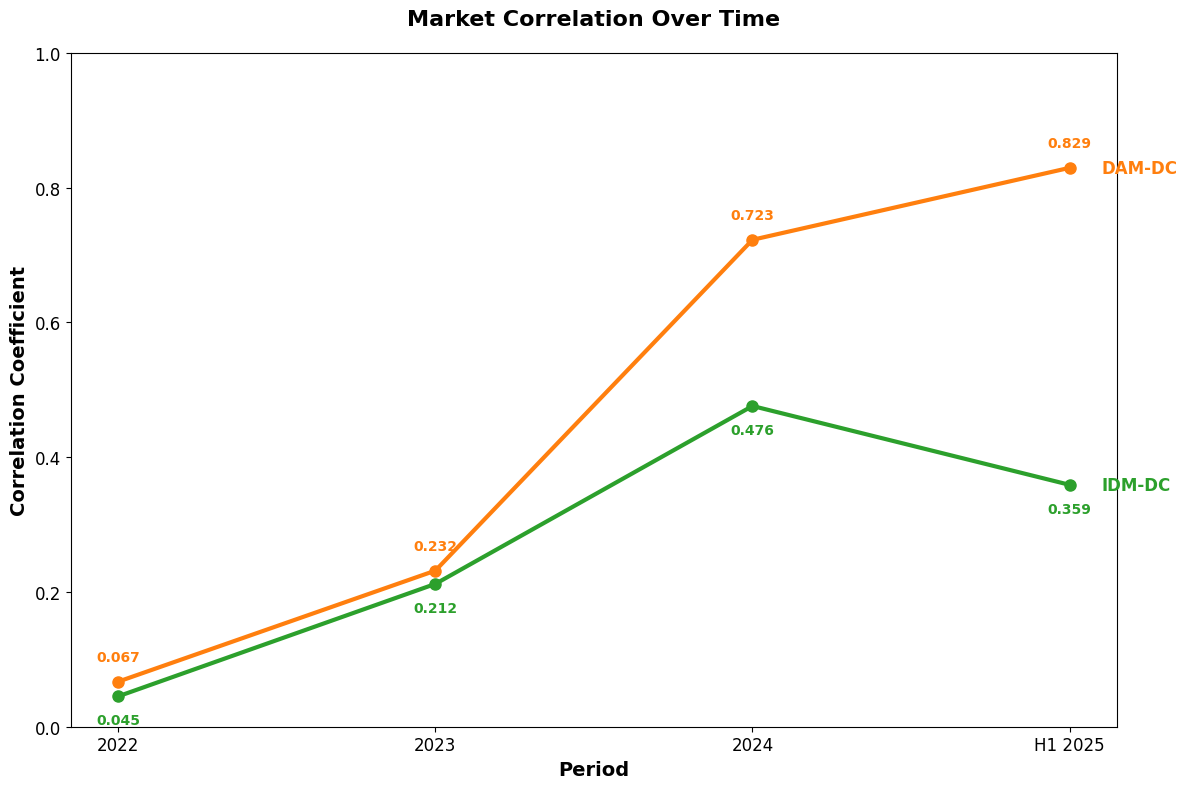


🔍 KEY INSIGHTS
2022.0: Strongest correlation = DAM-DC (0.067), Weakest = IDM-DC (0.045)
2023.0: Strongest correlation = DAM-DC (0.232), Weakest = IDM-DC (0.212)
2024.0: Strongest correlation = DAM-DC (0.723), Weakest = IDM-DC (0.476)
H1 2025: Strongest correlation = DAM-DC (0.829), Weakest = IDM-DC (0.359)


In [3]:
# Calculate correlation between DAM-DC and IDM-DC markets for each year (excluding DAM-IDM)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_market_correlations_selected(processor, years=[2022, 2023, 2024, 2025], config_id=1):
    """
    Calculate correlations between DAM-DC and IDM-DC markets for each year
    Excludes DAM-IDM correlation as requested
    """
    
    print("🔍 MARKET CORRELATION ANALYSIS (DAM-DC & IDM-DC)")
    print("=" * 60)
    
    all_correlations = []
    config = next((c for c in BESS_CONFIGS if c['config_id'] == config_id), None)
    
    if config is None:
        print(f"Config {config_id} not found")
        return None
    
    print(f"Using Config {config_id} ({config['power_mw']}MW/{config['energy_mwh']}MWh) for correlation analysis")
    print()
    
    for year in years:
        try:
            print(f"📊 Analyzing {year}...")
            
            # Get market profits for this year
            profits_df = processor.calculate_market_profits(year, config['power_mw'], config['energy_mwh'])
            
            if len(profits_df) == 0:
                print(f"    ❌ No data available for {year}")
                continue
            
            # Calculate correlations (excluding DAM-IDM)
            dam_values = profits_df['DAM_Daily_Profit_per_MW'].values
            idm_values = profits_df['IDM_Daily_Profit_per_MW'].values
            dc_values = profits_df['DC_Daily_Profit_per_MW'].values
            
            # Only calculate DAM-DC and IDM-DC correlations
            corr_dam_dc = np.corrcoef(dam_values, dc_values)[0, 1]
            corr_idm_dc = np.corrcoef(idm_values, dc_values)[0, 1]
            
            # Statistical significance tests
            _, p_dam_dc = stats.pearsonr(dam_values, dc_values)
            _, p_idm_dc = stats.pearsonr(idm_values, dc_values)
            
            # Basic statistics
            dam_mean = np.mean(dam_values)
            idm_mean = np.mean(idm_values)
            dc_mean = np.mean(dc_values)
            
            dam_std = np.std(dam_values)
            idm_std = np.std(idm_values)
            dc_std = np.std(dc_values)
            
            correlation_data = {
                'year': year,
                'days_analyzed': len(profits_df),
                'dam_mean': round(dam_mean, 2),
                'idm_mean': round(idm_mean, 2),
                'dc_mean': round(dc_mean, 2),
                'dam_std': round(dam_std, 2),
                'idm_std': round(idm_std, 2),
                'dc_std': round(dc_std, 2),
                'corr_dam_dc': round(corr_dam_dc, 4),
                'corr_idm_dc': round(corr_idm_dc, 4),
                'p_dam_dc': round(p_dam_dc, 4),
                'p_idm_dc': round(p_idm_dc, 4)
            }
            
            all_correlations.append(correlation_data)
            
            print(f"    ✅ {len(profits_df)} days analyzed")
            print(f"    📈 DAM-DC correlation:  {corr_dam_dc:.4f} (p={p_dam_dc:.4f})")
            print(f"    📈 IDM-DC correlation:  {corr_idm_dc:.4f} (p={p_idm_dc:.4f})")
            
            # Significance indicators
            sig_indicators = []
            if p_dam_dc < 0.001: sig_indicators.append("DAM-DC***")
            elif p_dam_dc < 0.01: sig_indicators.append("DAM-DC**")
            elif p_dam_dc < 0.05: sig_indicators.append("DAM-DC*")
            
            if p_idm_dc < 0.001: sig_indicators.append("IDM-DC***")
            elif p_idm_dc < 0.01: sig_indicators.append("IDM-DC**")
            elif p_idm_dc < 0.05: sig_indicators.append("IDM-DC*")
            
            if sig_indicators:
                print(f"    🔥 Significant correlations: {', '.join(sig_indicators)}")
            print()
            
        except Exception as e:
            print(f"    ❌ Error analyzing {year}: {e}")
            print()
    
    return pd.DataFrame(all_correlations)

def create_correlation_time_series_plot(correlation_df):
    """Create time series plot of correlations with labels on lines and dots for all points"""
    
    if correlation_df is None or len(correlation_df) == 0:
        print("No correlation data to visualize")
        return
    
    # Create time series plot of correlations
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    years = correlation_df['year'].values
    dam_dc_corr = correlation_df['corr_dam_dc'].values
    idm_dc_corr = correlation_df['corr_idm_dc'].values
    
    # Create custom labels
    year_labels = []
    for year in years:
        if year == 2025:
            year_labels.append('H1 2025')
        else:
            year_labels.append(str(year))
    
    # Plot lines with dots for all data points
    ax.plot(range(len(years)), dam_dc_corr, 'o-', linewidth=3, markersize=8, 
            color='#ff7f0e')
    ax.plot(range(len(years)), idm_dc_corr, 'o-', linewidth=3, markersize=8, 
            color='#2ca02c')
    
    # Set custom x-axis labels
    ax.set_xticks(range(len(years)))
    ax.set_xticklabels(year_labels)
    
    ax.set_xlabel('Period', fontsize=14, fontweight='bold')
    ax.set_ylabel('Correlation Coefficient', fontsize=14, fontweight='bold')
    ax.set_title('Market Correlation Over Time', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(0, 1)  # Start y-axis from zero
    
    # Enhance the plot appearance
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add labels directly on the lines
    # Find good positions for labels (near the end of each line)
    label_x_pos = len(years) - 1  # Position at the last data point
    
    # DAM-DC label
    ax.text(label_x_pos + 0.1, dam_dc_corr[-1], 'DAM-DC', 
           fontsize=12, fontweight='bold', color='#ff7f0e', 
           va='center', ha='left')
    
    # IDM-DC label  
    ax.text(label_x_pos + 0.1, idm_dc_corr[-1], 'IDM-DC', 
           fontsize=12, fontweight='bold', color='#2ca02c',
           va='center', ha='left')
    
    # Add value labels on points (no boxes)
    for i, (dam_corr, idm_corr) in enumerate(zip(dam_dc_corr, idm_dc_corr)):
        ax.annotate(f'{dam_corr:.3f}', (i, dam_corr), 
                   textcoords="offset points", xytext=(0,15), ha='center', fontsize=10, 
                   color='#ff7f0e', fontweight='bold')
        ax.annotate(f'{idm_corr:.3f}', (i, idm_corr), 
                   textcoords="offset points", xytext=(0,-20), ha='center', fontsize=10,
                   color='#2ca02c', fontweight='bold')
    
    # Adjust plot margins to accommodate labels
    plt.subplots_adjust(right=0.85)
    plt.tight_layout()
    plt.show()

# Execute correlation analysis
if 'processor' in globals() and CPLEX_AVAILABLE:
    correlation_results = calculate_market_correlations_selected(processor, years=[2022, 2023, 2024, 2025])
    
    if correlation_results is not None and len(correlation_results) > 0:
        print("\n" + "=" * 80)
        print("📊 MARKET CORRELATION SUMMARY TABLE (DAM-DC & IDM-DC)")
        print("=" * 80)
        
        # Display summary table
        display_cols = ['year', 'days_analyzed', 'corr_dam_dc', 'corr_idm_dc', 'p_dam_dc', 'p_idm_dc']
        print(correlation_results[display_cols].to_string(index=False))
        
        print("\n" + "=" * 80)
        print("📈 MARKET STATISTICS SUMMARY")
        print("=" * 80)
        
        stats_cols = ['year', 'dam_mean', 'idm_mean', 'dc_mean', 'dam_std', 'idm_std', 'dc_std']
        print(correlation_results[stats_cols].to_string(index=False))
        
        print("\n📌 Significance levels: *** p<0.001, ** p<0.01, * p<0.05")
        
        # Create visualization with updated styling
        create_correlation_time_series_plot(correlation_results)
        
        # Find strongest and weakest correlations
        print("\n" + "=" * 60)
        print("🔍 KEY INSIGHTS")
        print("=" * 60)
        
        for _, row in correlation_results.iterrows():
            year = row['year']
            year_label = 'H1 2025' if year == 2025 else str(year)
            correlations = [
                ('DAM-DC', row['corr_dam_dc']),
                ('IDM-DC', row['corr_idm_dc'])
            ]
            
            strongest = max(correlations, key=lambda x: abs(x[1]))
            weakest = min(correlations, key=lambda x: abs(x[1]))
            
            print(f"{year_label}: Strongest correlation = {strongest[0]} ({strongest[1]:.3f}), "
                  f"Weakest = {weakest[0]} ({weakest[1]:.3f})")
    
else:
    print("❌ Cannot perform correlation analysis: processor not available or CPLEX missing")

🔍 MARKET CORRELATION ANALYSIS 2022-2024 (DAM-DC & IDM-DC)
Using Config 1 (10MW/10MWh) for correlation analysis

📊 Analyzing 2022...
    ✅ 365 days analyzed
    📈 DAM-DC correlation:  0.0669 (p=0.2024)
    📈 IDM-DC correlation:  0.0451 (p=0.3905)

📊 Analyzing 2023...
    ✅ 365 days analyzed
    📈 DAM-DC correlation:  0.2316 (p=0.0000)
    📈 IDM-DC correlation:  0.2119 (p=0.0000)
    🔥 Significant correlations: DAM-DC***, IDM-DC***

📊 Analyzing 2024...
    ✅ 366 days analyzed
    📈 DAM-DC correlation:  0.7225 (p=0.0000)
    📈 IDM-DC correlation:  0.4759 (p=0.0000)
    🔥 Significant correlations: DAM-DC***, IDM-DC***


📊 MARKET CORRELATION SUMMARY TABLE 2022-2024 (DAM-DC & IDM-DC)
 year  days_analyzed  corr_dam_dc  corr_idm_dc  p_dam_dc  p_idm_dc
 2022            365       0.0669       0.0451    0.2024    0.3905
 2023            365       0.2316       0.2119    0.0000    0.0000
 2024            366       0.7225       0.4759    0.0000    0.0000

📈 MARKET STATISTICS SUMMARY 2022-2024
 year 

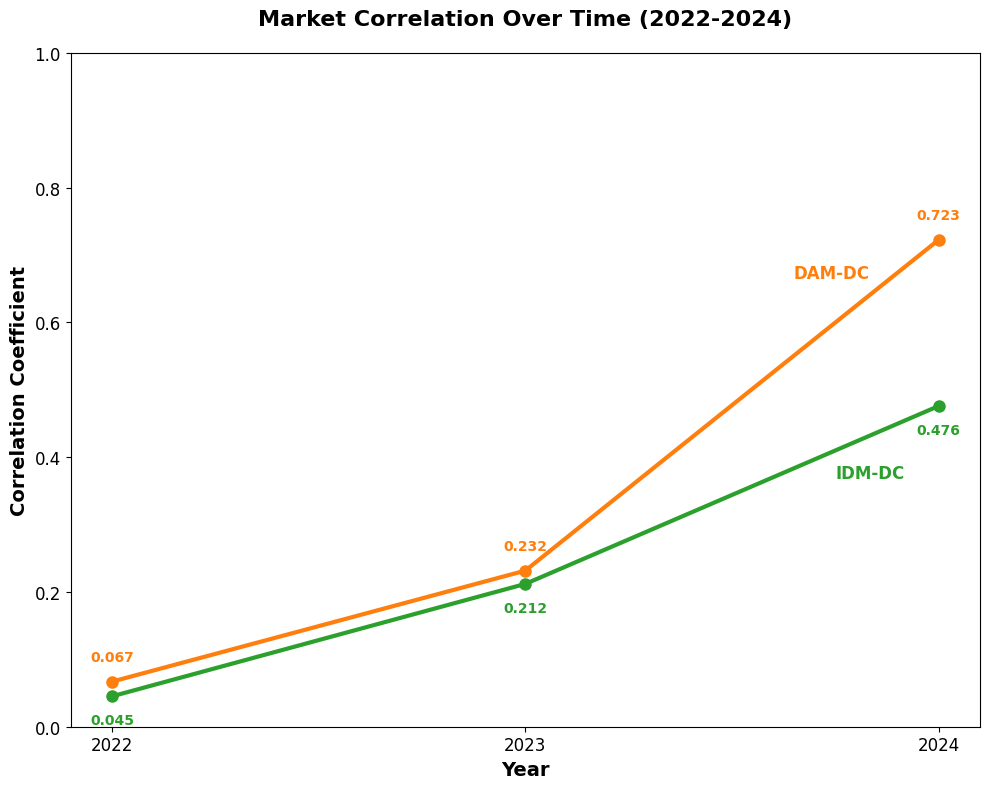


🔍 KEY INSIGHTS (2022-2024)
2022: Strongest correlation = DAM-DC (0.067), Weakest = IDM-DC (0.045)
2023: Strongest correlation = DAM-DC (0.232), Weakest = IDM-DC (0.212)
2024: Strongest correlation = DAM-DC (0.723), Weakest = IDM-DC (0.476)


In [4]:
# Calculate correlation between DAM-DC and IDM-DC markets for 2022-2024 only (excluding 2025)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_market_correlations_2022_2024(processor, years=[2022, 2023, 2024], config_id=1):
    """
    Calculate correlations between DAM-DC and IDM-DC markets for 2022-2024 only
    Excludes DAM-IDM correlation and 2025 data
    """
    
    print("🔍 MARKET CORRELATION ANALYSIS 2022-2024 (DAM-DC & IDM-DC)")
    print("=" * 60)
    
    all_correlations = []
    config = next((c for c in BESS_CONFIGS if c['config_id'] == config_id), None)
    
    if config is None:
        print(f"Config {config_id} not found")
        return None
    
    print(f"Using Config {config_id} ({config['power_mw']}MW/{config['energy_mwh']}MWh) for correlation analysis")
    print()
    
    for year in years:
        try:
            print(f"📊 Analyzing {year}...")
            
            # Get market profits for this year
            profits_df = processor.calculate_market_profits(year, config['power_mw'], config['energy_mwh'])
            
            if len(profits_df) == 0:
                print(f"    ❌ No data available for {year}")
                continue
            
            # Calculate correlations (excluding DAM-IDM)
            dam_values = profits_df['DAM_Daily_Profit_per_MW'].values
            idm_values = profits_df['IDM_Daily_Profit_per_MW'].values
            dc_values = profits_df['DC_Daily_Profit_per_MW'].values
            
            # Only calculate DAM-DC and IDM-DC correlations
            corr_dam_dc = np.corrcoef(dam_values, dc_values)[0, 1]
            corr_idm_dc = np.corrcoef(idm_values, dc_values)[0, 1]
            
            # Statistical significance tests
            _, p_dam_dc = stats.pearsonr(dam_values, dc_values)
            _, p_idm_dc = stats.pearsonr(idm_values, dc_values)
            
            # Basic statistics
            dam_mean = np.mean(dam_values)
            idm_mean = np.mean(idm_values)
            dc_mean = np.mean(dc_values)
            
            dam_std = np.std(dam_values)
            idm_std = np.std(idm_values)
            dc_std = np.std(dc_values)
            
            correlation_data = {
                'year': year,
                'days_analyzed': len(profits_df),
                'dam_mean': round(dam_mean, 2),
                'idm_mean': round(idm_mean, 2),
                'dc_mean': round(dc_mean, 2),
                'dam_std': round(dam_std, 2),
                'idm_std': round(idm_std, 2),
                'dc_std': round(dc_std, 2),
                'corr_dam_dc': round(corr_dam_dc, 4),
                'corr_idm_dc': round(corr_idm_dc, 4),
                'p_dam_dc': round(p_dam_dc, 4),
                'p_idm_dc': round(p_idm_dc, 4)
            }
            
            all_correlations.append(correlation_data)
            
            print(f"    ✅ {len(profits_df)} days analyzed")
            print(f"    📈 DAM-DC correlation:  {corr_dam_dc:.4f} (p={p_dam_dc:.4f})")
            print(f"    📈 IDM-DC correlation:  {corr_idm_dc:.4f} (p={p_idm_dc:.4f})")
            
            # Significance indicators
            sig_indicators = []
            if p_dam_dc < 0.001: sig_indicators.append("DAM-DC***")
            elif p_dam_dc < 0.01: sig_indicators.append("DAM-DC**")
            elif p_dam_dc < 0.05: sig_indicators.append("DAM-DC*")
            
            if p_idm_dc < 0.001: sig_indicators.append("IDM-DC***")
            elif p_idm_dc < 0.01: sig_indicators.append("IDM-DC**")
            elif p_idm_dc < 0.05: sig_indicators.append("IDM-DC*")
            
            if sig_indicators:
                print(f"    🔥 Significant correlations: {', '.join(sig_indicators)}")
            print()
            
        except Exception as e:
            print(f"    ❌ Error analyzing {year}: {e}")
            print()
    
    return pd.DataFrame(all_correlations)

def create_correlation_plot_2022_2024(correlation_df):
    """Create time series plot of correlations for 2022-2024 with labels on lines and dots"""
    
    if correlation_df is None or len(correlation_df) == 0:
        print("No correlation data to visualize")
        return
    
    # Create time series plot of correlations
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    years = correlation_df['year'].values
    dam_dc_corr = correlation_df['corr_dam_dc'].values
    idm_dc_corr = correlation_df['corr_idm_dc'].values
    
    # Create year labels (no custom H1 2025 label needed)
    year_labels = [str(year) for year in years]
    
    # Plot lines with dots for all data points
    ax.plot(range(len(years)), dam_dc_corr, 'o-', linewidth=3, markersize=8, 
            color='#ff7f0e')
    ax.plot(range(len(years)), idm_dc_corr, 'o-', linewidth=3, markersize=8, 
            color='#2ca02c')
    
    # Set custom x-axis labels
    ax.set_xticks(range(len(years)))
    ax.set_xticklabels(year_labels)
    
    ax.set_xlabel('Year', fontsize=14, fontweight='bold')
    ax.set_ylabel('Correlation Coefficient', fontsize=14, fontweight='bold')
    ax.set_title('Market Correlation Over Time (2022-2024)', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_ylim(0, 1)  # Start y-axis from zero
    
    # Enhance the plot appearance
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add labels directly on the lines
    # Find good positions for labels (near the end of each line)
    label_x_pos = len(years) - 1  # Position at the last data point
    
    # DAM-DC label
    ax.text(label_x_pos - 0.35, dam_dc_corr[-1]-0.05, 'DAM-DC', 
           fontsize=12, fontweight='bold', color='#ff7f0e', 
           va='center', ha='left')
    
    # IDM-DC label  
    ax.text(label_x_pos - 0.25, idm_dc_corr[-1]-0.1, 'IDM-DC', 
           fontsize=12, fontweight='bold', color='#2ca02c',
           va='center', ha='left')
    
    # Add value labels on points (no boxes)
    for i, (dam_corr, idm_corr) in enumerate(zip(dam_dc_corr, idm_dc_corr)):
        ax.annotate(f'{dam_corr:.3f}', (i, dam_corr), 
                   textcoords="offset points", xytext=(0,15), ha='center', fontsize=10, 
                   color='#ff7f0e', fontweight='bold')
        ax.annotate(f'{idm_corr:.3f}', (i, idm_corr), 
                   textcoords="offset points", xytext=(0,-20), ha='center', fontsize=10,
                   color='#2ca02c', fontweight='bold')
    
    # Adjust plot margins to accommodate labels
    plt.subplots_adjust(right=0.85)
    plt.tight_layout()
    plt.show()

# Execute correlation analysis for 2022-2024 only
if 'processor' in globals() and CPLEX_AVAILABLE:
    correlation_results_2022_2024 = calculate_market_correlations_2022_2024(processor, years=[2022, 2023, 2024])
    
    if correlation_results_2022_2024 is not None and len(correlation_results_2022_2024) > 0:
        print("\n" + "=" * 80)
        print("📊 MARKET CORRELATION SUMMARY TABLE 2022-2024 (DAM-DC & IDM-DC)")
        print("=" * 80)
        
        # Display summary table
        display_cols = ['year', 'days_analyzed', 'corr_dam_dc', 'corr_idm_dc', 'p_dam_dc', 'p_idm_dc']
        print(correlation_results_2022_2024[display_cols].to_string(index=False))
        
        print("\n" + "=" * 80)
        print("📈 MARKET STATISTICS SUMMARY 2022-2024")
        print("=" * 80)
        
        stats_cols = ['year', 'dam_mean', 'idm_mean', 'dc_mean', 'dam_std', 'idm_std', 'dc_std']
        print(correlation_results_2022_2024[stats_cols].to_string(index=False))
        
        print("\n📌 Significance levels: *** p<0.001, ** p<0.01, * p<0.05")
        
        # Create visualization for 2022-2024 only
        create_correlation_plot_2022_2024(correlation_results_2022_2024)
        
        # Find strongest and weakest correlations
        print("\n" + "=" * 60)
        print("🔍 KEY INSIGHTS (2022-2024)")
        print("=" * 60)
        
        for _, row in correlation_results_2022_2024.iterrows():
            year = int(row['year'])
            correlations = [
                ('DAM-DC', row['corr_dam_dc']),
                ('IDM-DC', row['corr_idm_dc'])
            ]
            
            strongest = max(correlations, key=lambda x: abs(x[1]))
            weakest = min(correlations, key=lambda x: abs(x[1]))
            
            print(f"{year}: Strongest correlation = {strongest[0]} ({strongest[1]:.3f}), "
                  f"Weakest = {weakest[0]} ({weakest[1]:.3f})")
    
else:
    print("❌ Cannot perform correlation analysis: processor not available or CPLEX missing")